In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

import numpy
from tqdm import tqdm
from matplotlib import pyplot as plt
import cv2

torch.set_printoptions(precision=4, sci_mode=False)
numpy.set_printoptions(precision=4, suppress=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./mnist', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False, drop_last=False)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
data_iter = iter(train_loader)
images, labels = next(data_iter)

In [8]:
class MLP_no_relu(nn.Module):

    def __init__(self):
        super(MLP_no_relu, self).__init__()
        self.l1 = torch.nn.Linear(784, 512)
        self.l2 = torch.nn.Linear(512, 256)
        self.l3 = torch.nn.Linear(256, 128)
        self.l4 = torch.nn.Linear(128, 64)
        self.l5 = torch.nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        
        return x

In [9]:
NUM_EPOCHS = 20
LEARNING_RATE = 0.01

model = MLP_no_relu().to(device)
# summary(model, (1, 28, 28))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [12]:
def new_learning_rate(loss):
    if loss <= 1:
        return 0.00001
    elif loss <= 2:
        return 0.0001
    elif loss <= 20:
        return 0.001
    elif loss <= 25:
        return 0.005
    elif loss <= 40:
        return 0.01
    else:
        return 0.01


for epoch in range(NUM_EPOCHS):
    total_loss = 0
    model.train()
    
    for _, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        model = model.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f'Epoch {epoch} \tLoss: {total_loss}')
    
    new_lr = new_learning_rate(total_loss)
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr
    


Epoch 0 	Loss: 128.81024078279734
Epoch 1 	Loss: 128.7366259470582
Epoch 2 	Loss: 127.40414538234472
Epoch 3 	Loss: 127.0491691455245
Epoch 4 	Loss: 126.87331414967775
Epoch 5 	Loss: 126.6406444311142
Epoch 6 	Loss: 125.75668703764677
Epoch 7 	Loss: 125.53404252976179
Epoch 8 	Loss: 125.02325777709484
Epoch 9 	Loss: 124.83307196199894
Epoch 10 	Loss: 124.3319096043706
Epoch 11 	Loss: 124.10798792541027
Epoch 12 	Loss: 123.84596453607082
Epoch 13 	Loss: 123.7253153398633
Epoch 14 	Loss: 123.32728912681341
Epoch 15 	Loss: 122.84540646523237
Epoch 16 	Loss: 122.77468118816614
Epoch 17 	Loss: 122.25802295655012
Epoch 18 	Loss: 122.3440076187253
Epoch 19 	Loss: 121.8569701090455


In [13]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 92.20%


In [13]:
# img = cv2.imread('/home/yoyo0125/Programs/HandWriteRecognize_NN/IMG01.jpg')
# img.shape
image = images.to(device)
ans = model(image)
ans[0], ans[0].argmax()

(tensor([-4.47259521, -3.45999026, -0.94826537, -1.26604509,  4.58980322,
         -3.59521008, -4.40513039,  8.20609665,  0.75413740,  9.66033649],
        device='cuda:0', grad_fn=<SelectBackward0>),
 tensor(9, device='cuda:0'))

In [22]:
#y0 = numpy.array(ans.cpu().detach().numpy()).flatten()
y0 = numpy.array([1, 1, 4, 5, 1, 4, 1, 9, 1, 9], dtype=numpy.float32)

W_5, b_5 = model.l5.weight.cpu().detach().numpy(), model.l5.bias.cpu().detach().numpy()
y1, residuals, rank, s = numpy.linalg.lstsq(W_5, y0 - b_5, rcond=None)

W_4, b_4 = model.l4.weight.cpu().detach().numpy(), model.l4.bias.cpu().detach().numpy()
y2, residuals, rank, s = numpy.linalg.lstsq(W_4, y1 - b_4, rcond=None)

W_3, b_3 = model.l3.weight.cpu().detach().numpy(), model.l3.bias.cpu().detach().numpy()
y3, residuals, rank, s = numpy.linalg.lstsq(W_3, y2 - b_3, rcond=None)

W_2, b_2 = model.l2.weight.cpu().detach().numpy(), model.l2.bias.cpu().detach().numpy()
y4, residuals, rank, s = numpy.linalg.lstsq(W_2, y3 - b_2, rcond=None)

W_1, b_1 = model.l1.weight.cpu().detach().numpy(), model.l1.bias.cpu().detach().numpy()
y5, residuals, rank, s = numpy.linalg.lstsq(W_1, y4 - b_1, rcond=None)

res = y5.reshape(28, 28)
res

array([[ -12.1934,  -27.5752,  -14.6299,    1.1968,   -2.6871,   -6.4447,
          -3.9561,  -29.2775,   38.7953,  -27.1995,  -12.6729,   -9.551 ,
         -30.8349,  -82.1631,   14.7399,   -6.9548,   26.1845,   11.8413,
         -14.7154,   -9.5882,  -16.3155,   -2.0974,    5.9894,  -18.578 ,
         -25.5865,  -18.6052,  -18.0207,   23.1961],
       [  37.4858,   -4.4429,    8.1483,  -67.7541,   -1.4554,  -15.0796,
          -0.2172,  -12.5562,  -29.6831,  -33.6396,   -9.3064,  -14.5864,
          25.9272,  -19.0189,    3.0141,   13.0397,  -31.112 ,   18.1841,
         -32.4384,  -30.3932,   35.0694,   -1.3867,   -3.9145,    4.1121,
           1.1592,   46.478 ,  -50.5245,  -24.2044],
       [  48.9018,   -6.7629,   -5.5094,   14.24  ,    2.88  ,  -16.1928,
          10.2128,   13.5595,   32.7223,   28.779 ,   57.4674,   19.8234,
          -9.335 ,   23.5825,   25.6415,  -11.2322,   38.4348,   39.3546,
           3.2723,  -10.0809,   42.7632,    3.6654,  -28.3691,  -16.807 ,
      

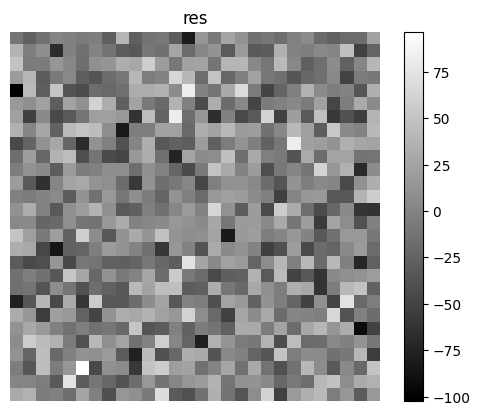

In [24]:
plt.imshow(res, cmap='gray')
plt.title('res')
plt.colorbar()
plt.axis('off')
plt.show()

In [23]:
y5_tensor = torch.tensor(y5, dtype=torch.float32)
y5_tensor = y5_tensor.to(device)
model(y5_tensor)

tensor([[1.0000, 1.0000, 4.0000, 5.0000, 1.0000, 4.0000, 1.0000, 9.0000, 1.0000,
         9.0000]], device='cuda:0', grad_fn=<AddmmBackward0>)